<a href="https://colab.research.google.com/github/algroznykh/notebooks/blob/master/clip_embeddings_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#load model

In [2]:
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-j1lsl7og
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-j1lsl7og
     |████████████████████████████████| 64 kB 2.4 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369106 sha256=b8f11cdaf6a1f9442c1487eb7ad4e4488c770df5fc5699881fc462fe91e80d43
  Stored in directory: /tmp/pip-ephem-wheel-cache-bnf02k6u/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=f495f9873f0a2961a1bf2d71f11c9710eb9c25abade154c469d5d0bdb0b0a17f
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built clip ftfy


In [3]:

import numpy as np
import torch
import sklearn

In [4]:


import clip

clip.available_models()



['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [5]:
model, preprocess = clip.load("RN50")
model.cuda().eval()

100%|███████████████████████████████████████| 244M/244M [00:07<00:00, 34.1MiB/s]


CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn

In [6]:
input_resolution = model.visual.input_resolution

In [7]:
input_resolution

224

# one embedding

In [8]:
from PIL import Image

In [9]:
shape = (input_resolution, input_resolution, 3)
ima = np.random.normal(size=shape, scale=.42).astype(np.float32)


In [10]:
im = Image.fromarray((ima * 255).astype('uint8'))

In [11]:
image = im.convert("RGB")

In [12]:

image_input = torch.tensor(np.expand_dims(preprocess(image), 0)).cuda()

In [13]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

In [14]:
image_features.shape

torch.Size([1, 1024])

In [15]:
image_features

tensor([[ 0.0145, -0.0440, -0.0762,  ..., -0.0042,  0.0097, -0.0737]],
       device='cuda:0')

In [16]:
import seaborn as sns


In [17]:
image_features[0]

tensor([ 0.0145, -0.0440, -0.0762,  ..., -0.0042,  0.0097, -0.0737],
       device='cuda:0')

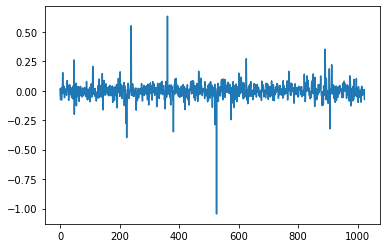

In [18]:
sns.lineplot(data=image_features[0].cpu().numpy())

In [19]:
image_features /= image_features.norm(dim=-1, keepdim=True)
image_features.cpu().numpy() @ image_features.cpu().numpy().T

array([[1.]], dtype=float32)

# batch embeddings

In [20]:
from torchvision import datasets, utils
from torchvision.transforms import ToTensor

In [21]:
data = datasets.CIFAR10(
    root="data",
    download=True,
    # transform=ToTensor()
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


In [22]:
from matplotlib import pyplot as plt

In [23]:
# Image.fromarray((data[0][0].moveaxis(0, -1).cpu().numpy()*255).astype('uint8')).resize((244,244), Image.NEAREST)

In [24]:
ims = [data[i][0] for i in (np.random.randint(len(data)) for i in range(100))]

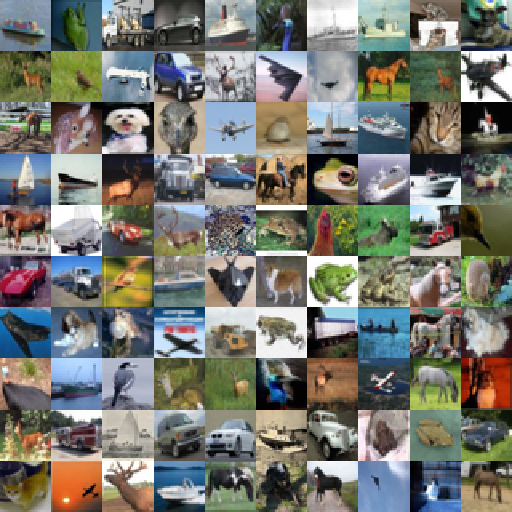

In [25]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_grid(ims, 10, 10).resize((512,512), Image.NEAREST)

In [26]:
# for tensors
# Image.fromarray((utils.make_grid(ims, nrow=3).moveaxis(0, -1).cpu().numpy() * 255).astype('uint8')).resize((244 * 3, 244 * 3), Image.NEAREST)

In [27]:
image_inputs = torch.tensor(np.stack([preprocess(im) for im in ims])).cuda()

In [28]:
with torch.no_grad():
    image_features = model.encode_image(image_inputs).float()

In [29]:
from sklearn.metrics.pairwise import cosine_similarity  

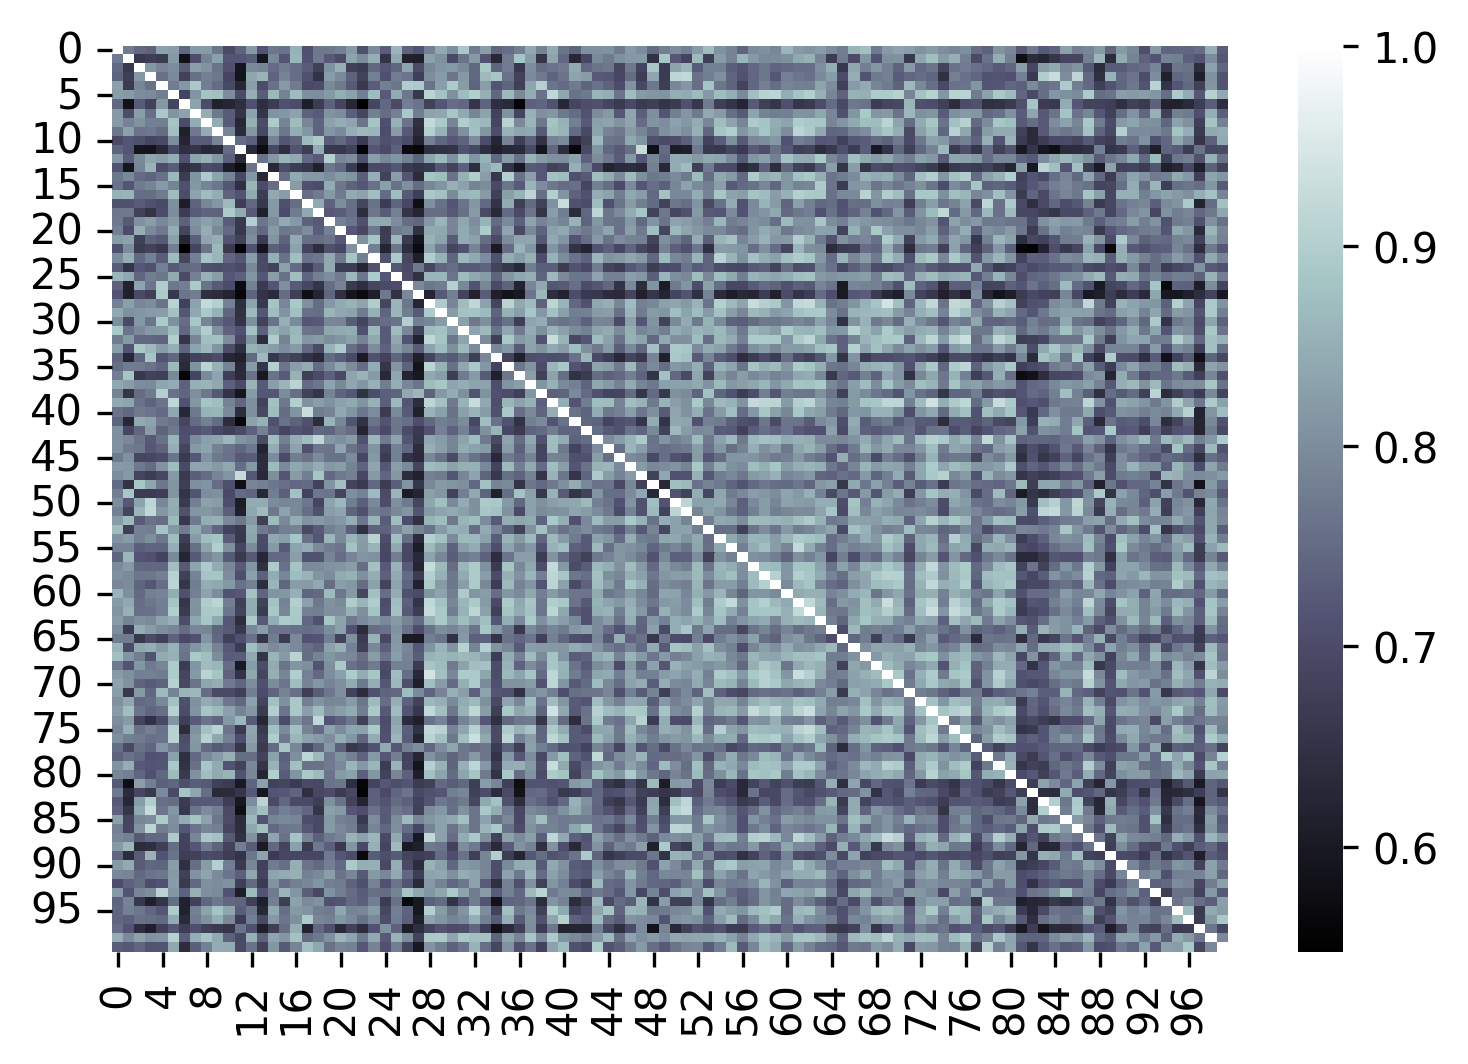

In [30]:
plt.figure(dpi=300)
sns.heatmap(data=cosine_similarity(image_features.cpu().numpy(), image_features.cpu().numpy()), cmap='bone')

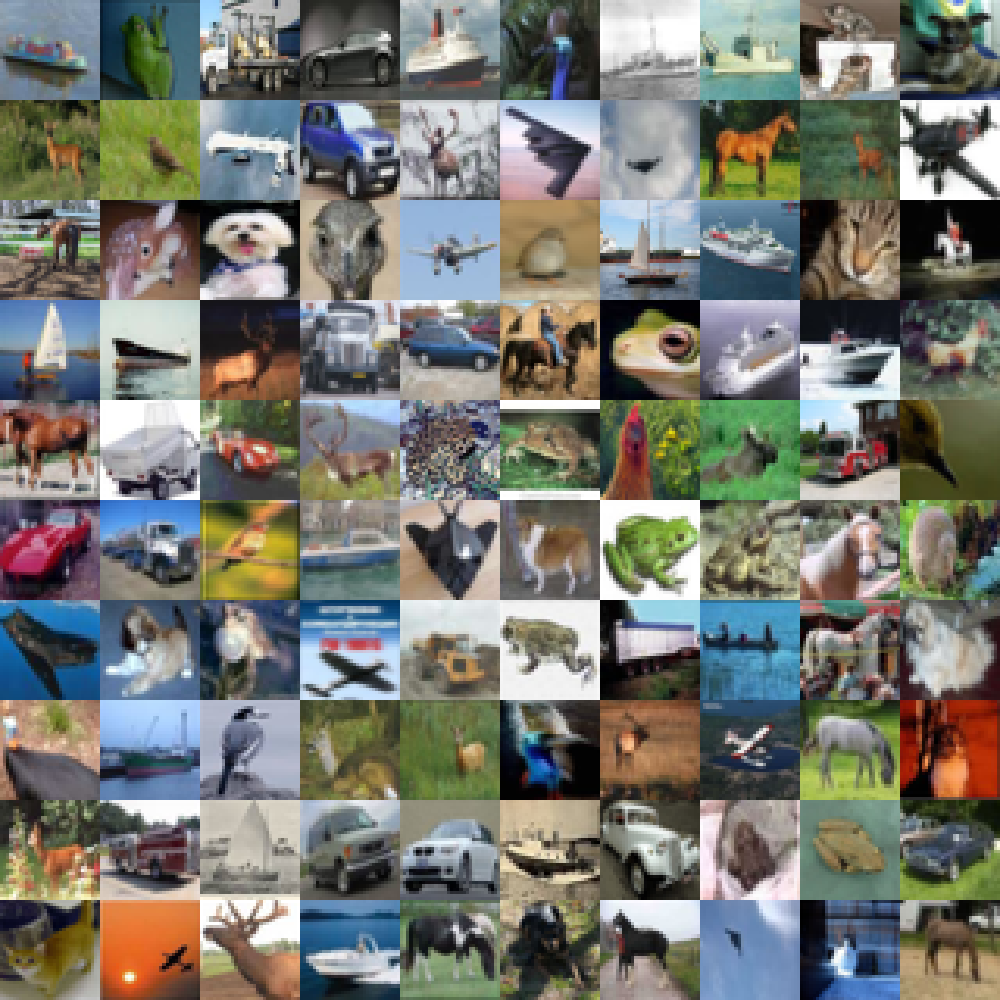

In [31]:
image_grid(ims, 10, 10).resize((1000,1000), Image.NEAREST)

# Similarity search

In [117]:
def get_nearest(ims, i, n):
    df = pd.DataFrame(cosine_similarity(image_features.cpu().numpy(), image_features.cpu().numpy()))
    return list(df[i].sort_values(ascending=False)[:n].index)



In [42]:
import pandas as pd

In [112]:
def sh(i, size=256):
    return ims[i].resize((size,size))

In [125]:
def hstack(images):
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)
    stacked = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in iter(images):
        stacked.paste(im, (x_offset,0))
        x_offset += im.size[0]

    return stacked

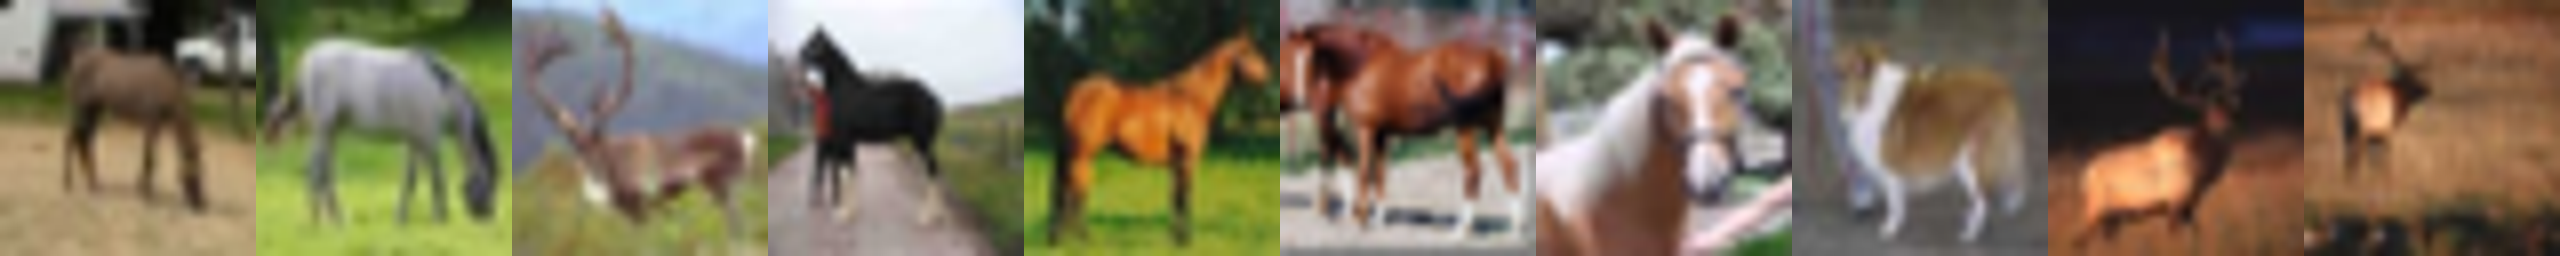

In [127]:
hstack([ims[i].resize((256,256)) for i in get_nearest(ims, 99, 10)])